In [98]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import tree

# 1. Get the suicidal dataset

## 1.1 Load all death data

In [2]:
#df_raw = pd.read_csv("../Morality Data/2020.csv",low_memory=False,nrows=10000)
df_raw = pd.read_csv("2020.csv")

C:\Users\hukai\AppData\Local\Temp\ipykernel_2408\3490527375.py:2: DtypeWarning: Columns (60,63,66,69,99,100,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("2020.csv")


In [3]:
features= df_raw.columns.tolist()
print(features,end="，")

['restatus', 'educ1989', 'educ2003', 'educflag', 'monthdth', 'sex', 'age', 'ageflag', 'ager52', 'ager27', 'ager12', 'ager22', 'placdth', 'marstat', 'weekday', 'year', 'injwork', 'mandeath', 'methdisp', 'autopsy', 'activity', 'injury', 'ucod', 'ucr358', 'ucr113', 'ucr130', 'ucr39', 'eanum', 'econdp_1', 'econds_1', 'enicon_1', 'econdp_2', 'econds_2', 'enicon_2', 'econdp_3', 'econds_3', 'enicon_3', 'econdp_4', 'econds_4', 'enicon_4', 'econdp_5', 'econds_5', 'enicon_5', 'econdp_6', 'econds_6', 'enicon_6', 'econdp_7', 'econds_7', 'enicon_7', 'econdp_8', 'econds_8', 'enicon_8', 'econdp_9', 'econds_9', 'enicon_9', 'econdp_10', 'econds_10', 'enicon_10', 'econdp_11', 'econds_11', 'enicon_11', 'econdp_12', 'econds_12', 'enicon_12', 'econdp_13', 'econds_13', 'enicon_13', 'econdp_14', 'econds_14', 'enicon_14', 'econdp_15', 'econds_15', 'enicon_15', 'econdp_16', 'econds_16', 'enicon_16', 'econdp_17', 'econds_17', 'enicon_17', 'econdp_18', 'econds_18', 'enicon_18', 'econdp_19', 'econds_19', 'enicon_

## 1.2 Fill the NaN 

In [4]:
df = df_raw.fillna(0)

In [5]:
df.describe()

,restatus,educ1989,educ2003,educflag,monthdth,age,ageflag,ager52,ager27,ager12,...,raceimp,racer3,racer5,hispanic,hspanicr,race40,occupation,occptnr,industry,indstryr
count,34426.000000,34426.0,34426.000000,34426.0,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,...,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.0,34426.0,34426.0,34426.0
mean,1.360629,0.0,3.082932,1.0,6.650061,1105.023732,0.000029,40.256405,20.315198,9.355255,...,0.037123,1.166880,1.186952,255.791756,2.500232,1.530064,0.0,0.0,0.0,0.0
std,0.537181,0.0,2.206495,0.0,3.496683,442.850876,0.005390,4.116438,3.602842,1.715623,...,0.237669,0.513981,0.631738,83.943738,1.549629,2.398543,0.0,0.0,0.0,0.0
min,1.000000,0.0,1.000000,1.0,1.000000,1001.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,100.000000,1.000000,1.000000,0.0,0.0,0.0,0.0
25%,1.000000,0.0,1.000000,1.0,4.000000,1065.000000,0.000000,39.000000,19.000000,9.000000,...,0.000000,1.000000,1.000000,260.000000,2.000000,1.000000,0.0,0.0,0.0,0.0
50%,1.000000,0.0,3.000000,1.0,7.000000,1077.000000,0.000000,41.000000,21.000000,10.000000,...,0.000000,1.000000,1.000000,260.000000,2.000000,1.000000,0.0,0.0,0.0,0.0
75%,2.000000,0.0,4.000000,1.0,10.000000,1086.000000,0.000000,43.000000,23.000000,11.000000,...,0.000000,1.000000,1.000000,260.000000,2.000000,1.000000,0.0,0.0,0.0,0.0
max,4.000000,0.0,9.000000,1.0,12.000000,9999.000000,1.000000,52.000000,27.000000,12.000000,...,2.000000,3.000000,4.000000,998.000000,9.000000,39.000000,0.0,0.0,0.0,0.0


## 1.3 Drop those columns with no data

In [6]:
df = df.loc[:, (df != 0).any(axis=0)]

In [7]:
df.describe()

,restatus,educ2003,educflag,monthdth,age,ageflag,ager52,ager27,ager12,ager22,...,econds_14,ranum,race,brace,raceimp,racer3,racer5,hispanic,hspanicr,race40
count,34426.000000,34426.000000,34426.0,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,...,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000,34426.000000
mean,1.360629,3.082932,1.0,6.650061,1105.023732,0.000029,40.256405,20.315198,9.355255,0.039040,...,0.000320,3.539999,2.382966,0.001307,0.037123,1.166880,1.186952,255.791756,2.500232,1.530064
std,0.537181,2.206495,0.0,3.496683,442.850876,0.005390,4.116438,3.602842,1.715623,0.654386,...,0.041398,1.535041,8.308837,0.036131,0.237669,0.513981,0.631738,83.943738,1.549629,2.398543
min,1.000000,1.000000,1.0,1.000000,1001.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,100.000000,1.000000,1.000000
25%,1.000000,1.000000,1.0,4.000000,1065.000000,0.000000,39.000000,19.000000,9.000000,0.000000,...,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,260.000000,2.000000,1.000000
50%,1.000000,3.000000,1.0,7.000000,1077.000000,0.000000,41.000000,21.000000,10.000000,0.000000,...,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,260.000000,2.000000,1.000000
75%,2.000000,4.000000,1.0,10.000000,1086.000000,0.000000,43.000000,23.000000,11.000000,0.000000,...,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,1.000000,260.000000,2.000000,1.000000
max,4.000000,9.000000,1.0,12.000000,9999.000000,1.000000,52.000000,27.000000,12.000000,22.000000,...,7.000000,14.000000,78.000000,1.000000,2.000000,3.000000,4.000000,998.000000,9.000000,39.000000


In [8]:
sum(df['mandeath'] == 7)

31294

## 1.4 Drop the data points that hasn't specified the manner of death

In [9]:
df = df.loc[df['mandeath'] != 0]

#### Manner of Death: 1. accident 2. suicide 3. homicide 4. pending investigation 5. could not determine 6. self-inflicted 7. natural Nan: Not Specified 

In [10]:
df["mandeath"].replace({2: 1, 1: 0,3: 0,4: 0,5: 0,6: 0,7: 0}, inplace=True)

Now we have the modified death data, mandeath == 1 is suicide, mandeath == other values means death caused by other reasons.

In [11]:
suicide = df

In [82]:
suicide.loc[suicide['mandeath'] == 0]

,restatus,educ2003,monthdth,sex,age,placdth,marstat,weekday,injwork,mandeath,...,race_Korean,race_Other Asian,race_Other Asian or Pacific Islander,race_Other Race,race_White,ICD_1,ICD_2,ICD_3,ICD_4,Age Group
0,1,3,1,M,72.0,1,M,4,U,0,...,0,0,0,0,0,C,9,5,0,Senior
1,1,3,1,M,43.0,3,M,5,U,0,...,0,0,0,0,0,C,3,4,0,Mid-age Adult
2,1,1,1,F,64.0,3,S,7,U,0,...,0,0,0,0,0,I,2,5,0,Senior
3,1,3,1,M,85.0,1,W,7,U,0,...,0,0,0,0,0,F,0,1,0,Senior
4,1,3,1,M,76.0,1,W,5,U,0,...,0,0,0,0,0,I,6,0,0,Senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34418,1,1,3,F,95.0,4,S,5,U,0,...,0,0,0,0,0,G,3,0,0,Senior
34419,1,3,3,F,80.0,4,W,2,U,0,...,0,0,0,0,0,I,3,5,0,Senior
34420,1,1,3,F,103.0,4,W,4,U,0,...,0,0,0,0,0,R,5,0,0,Senior
34422,1,4,3,F,65.0,1,M,1,U,0,...,0,0,0,0,1,D,6,4,0,Senior


#扔数据
年龄定义在12岁之后，因为之前的年龄都不一定

In [13]:
suicide_str = pd.DataFrame(suicide)
suicide_str['age'] = suicide['age'].apply(str)
age_NotSpecified = list(suicide_str[suicide_str['age'].str.contains('999')].index)
suicide = suicide.drop(index = age_NotSpecified, axis=1)
suicide['age'] = suicide['age'].apply(int)

## 1.5 Decoding the age:
#### 1. if the first digit is 1, then the last three digits represent the age under years.
#### 2. if the first digit is 2, then the last three digits represent the age under months.
#### 3. if the first digit is 4, then the last three digits represent the age under days.
#### 4. if the first digit is 5, then the last three digits represent the age under hours.
#### 5. if the first digit is 6, then the last three digits represent the age under minutes.
#### 6. if any three digits are 999, then the age is not speficied.

Here we filter out the index of keys with unspecified age, and get the index list to drop at next step.

In [14]:
suicide.loc[(suicide['age']>=1000)&(suicide['age']<2000),'age']= suicide['age'] - 1000
suicide.loc[(suicide['age']>=2000)&(suicide['age']<3000),'age']=(suicide['age']-2000)/12
suicide.loc[(suicide['age']>=4000)&(suicide['age']<5000),'age']=(suicide['age']-4000)/365
#Although we have people died when they were just a couple of hours old, we actually can ignore that since since they were that young, it is impossible for them to "commit a suicide"
suicide[(suicide['age']>=5000)&(suicide['age']<6000)]
suicide.loc[(suicide['age']>=5000)&(suicide['age']<6000),'age']=(suicide['age']-5000)/24/365
#I am so sorry that you died so young babe!
suicide[(suicide['age']>=6000)&(suicide['age']<7000)]
suicide.loc[(suicide['age']>=6000)&(suicide['age']<7000),'age']=(suicide['age']-6000)/60/24/365

We throw away rows with unspecified education levels.

In [15]:
suicide=suicide.loc[suicide['educ2003'] != 9]
suicide=suicide.loc[suicide['marstat'] != 'U']
suicide=suicide.loc[suicide['weekday'] != 9]
suicide=suicide.loc[suicide['placdth'] != 9]
suicide=suicide.loc[suicide['injury'] != 'U']

One hot Encoding for Sex

In [16]:
suicide = suicide.join(pd.get_dummies(suicide[["sex"]]))

One hot Encoding for Maritial Status

In [17]:
suicide = suicide.join(pd.get_dummies(suicide[["marstat"]]))

In [18]:
suicide["racer5"].replace({0:"Other(Puerto Rico only)",1: "White", 2: "Black",3: "American Indian",4:"Asian/Pacific Islander"}, inplace=True)

可能要先encode一下race 然后再去one hot encoding；

In [19]:
print(suicide.columns)
suicide=suicide.drop(columns=['educflag','econds_1','year','methdisp','autopsy',\
                      'ageflag','ager52', 'ager27', 'ager12', 'ager22',\
                      'brace','raceimp', 'racer3', 'hspanicr'])

Index(['restatus', 'educ2003', 'educflag', 'monthdth', 'sex', 'age', 'ageflag',
       'ager52', 'ager27', 'ager12', 'ager22', 'placdth', 'marstat', 'weekday',
       'year', 'injwork', 'mandeath', 'methdisp', 'autopsy', 'activity',
       'injury', 'ucod', 'ucr358', 'ucr113', 'ucr130', 'ucr39', 'eanum',
       'econdp_1', 'econds_1', 'enicon_1', 'econdp_2', 'econds_2', 'enicon_2',
       'econdp_3', 'econds_3', 'enicon_3', 'econdp_4', 'econds_4', 'enicon_4',
       'econdp_5', 'econds_5', 'enicon_5', 'econdp_6', 'econds_6', 'enicon_6',
       'econdp_7', 'econds_7', 'enicon_7', 'econdp_8', 'econds_8', 'enicon_8',
       'econdp_9', 'econds_9', 'enicon_9', 'econdp_10', 'econds_10',
       'enicon_10', 'econdp_11', 'econds_11', 'enicon_11', 'econdp_12',
       'econds_12', 'enicon_12', 'econdp_13', 'econds_13', 'enicon_13',
       'econdp_14', 'econds_14', 'enicon_14', 'ranum', 'record_1', 'record_2',
       'record_3', 'record_4', 'record_5', 'record_6', 'record_7', 'record_8',
       

1. ranum: Number of Entity-Axis Conditions 这个列出来了有多少个conditions
2. record_n: position number of nth condition
3. record_n: Sequence of condition within part/line

The record axis codes are assigned in terms of the set of codes that best describe the overall medical certification portion of the death certificate.

Refer to https://www.cdc.gov/nchs/data/datalinkage/underlying_and_multiple_cause_of_death_codes.pdf



In [20]:
suicide["raceforvis"]= suicide["race"]

In [21]:
suicide["race"].replace({0:"Other Race",1: "White", 2: "Black",3: "American Indian",4: "Chinese", 5: "Japanese",\
                         6: "Hawaiian",7: "Filipino",8:"Other Asian or Pacific Islander", 18: "Asian Indian",\
                         28: "Korean", 38: "Samoan",48:"Vietnamese", 58: "Guamanian", 68:"Other Asian",78:"Combined Other Asian"}, inplace=True)

In [22]:
suicide = suicide.join(pd.get_dummies(suicide[["race"]]))

出一个自杀情况下的 ICD-10 编码热力图 横轴（A,B,C,...) 纵轴(10,20,30,...),热力是数量
    这样我们就可以清楚地看到自杀的人的疾病记录大概率集中在哪个部分。
    

Let‘s define a function to split ICD code.

In [23]:
def concat_split(x,width=1):
    result=''
    start=0
    while True:
        s=str(x)[start:start+width]
        
        if s:
            result =result + s 
        else:
            break
        start=start+width
        
    return result[:-1]

In [24]:
ICD_Split = suicide['ucod'].map(concat_split).str.split('',expand=True)

In [25]:
ICD_Split.columns = ['ICD_'+str(i) for i in ICD_Split.columns]

In [26]:
ICD_Split['ICD_3']=ICD_Split['ICD_3'].replace({'':'0'})
ICD_Split['ICD_3']=ICD_Split['ICD_3'].apply(int)
ICD_Split['ICD_4']=ICD_Split['ICD_4'].replace({'':'0',None :'0'})
ICD_Split['ICD_4']=ICD_Split['ICD_4'].apply(int)
suicide = suicide.join(ICD_Split[['ICD_1','ICD_2','ICD_3','ICD_4']])

## 2 Descriptive Analysis

Pie Chart for 自杀人数占总死亡人数百分比

### 2.1 Underlying Cause of Suicide Analysis

#### 2.1.1 Heatmap of ICD-10 encoding system for Suicide cases.

<AxesSubplot:xlabel='ICD_2', ylabel='ICD_1'>

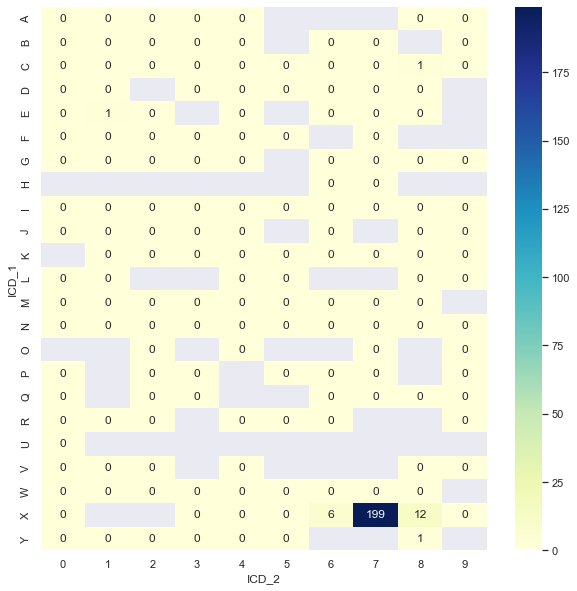

In [27]:
heattable = suicide.pivot_table(index = 'ICD_1', columns = 'ICD_2', values = 'mandeath', aggfunc = np.sum)
plt.figure(figsize=(10, 10))
sns.heatmap(data = heattable,cmap='YlGnBu', annot=True, fmt="g")

上图解释：X60-X84 这一块是ICD10系统里的X60-X84 故意自害，make sense
于是之后我们可以再dig into X7 这一块儿看看他们自杀的方式有哪些：具体可以查阅
https://zh.m.wikipedia.org/wiki/ICD-10_第二十章：疾病和死亡的外因
这里有一个假设，或许我们可以分析一下某个有自杀倾向的人，会倾向于用什么样的方式自杀，然后可以让他们远离这种东西。

From the Figure above we can see that most of the suicidal cases, the underlying cause of death belongs to X7**

### 2.1.2 Deeper insight into X7

We can dig into Block X7 and take a look inside to see the main method that people use to suicide.

<AxesSubplot:xlabel='ICD_4', ylabel='ICD_3'>

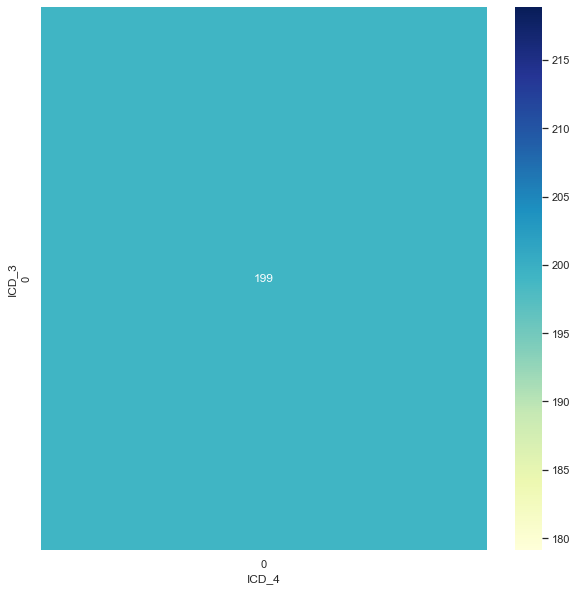

In [28]:
suicide_X=suicide[suicide['ICD_1']=="X"]
suicide_X7=suicide_X[suicide_X['ICD_2']=='7']
heattable_X7 = suicide_X7.pivot_table(index = 'ICD_3', columns = 'ICD_4',values='mandeath',aggfunc=np.sum)
plt.figure(figsize=(10, 10))
sns.heatmap(data = heattable_X7,cmap='YlGnBu',annot = True, fmt="g")

From the Figure above we can see they did not further define 

### 2.1.3 Other underlying cause of death

Let's remove Block X7 and see what other underlying causes of suicide.

<AxesSubplot:xlabel='ICD_2', ylabel='ICD_1'>

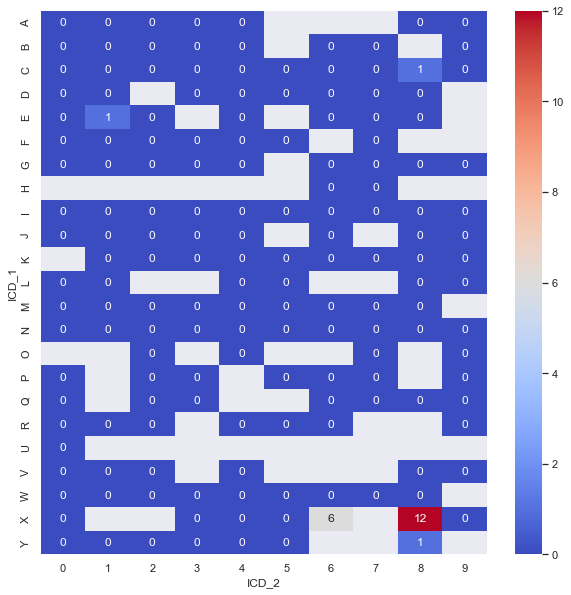

In [29]:
#suicide_other = suicide.loc[(suicide['ICD_1'] != "X")&(suicide['ICD_2'] != "7")]
#heaptable_other = suicide_other.pivot_table(index = 'ICD_1', columns = 'ICD_2', values = 'mandeath', aggfunc = np.sum)
plt.figure(figsize=(10, 10))
sns.heatmap(data = heattable,cmap='coolwarm', annot=True,fmt='g',mask = heattable == 199 )

### Let's refer to the ICD System, we can see that:
#### 1. There are 12 cases people's underlying cause of death is "Intentional self-harm by jumping from a high place"
#### 2. There are 6 peoples' ucod is "Intentional self-poisoning by and exposure to nonopioid analgesics, antipyretics and antirheumatics"
#### 3. There is 1 person's ucod is "Type 1 Diabetes"
#### 4. There is 1 person's ucod is "Malignant neoplasms"

## 2.2 Trends

<AxesSubplot:xlabel='weekday', ylabel='monthdth'>

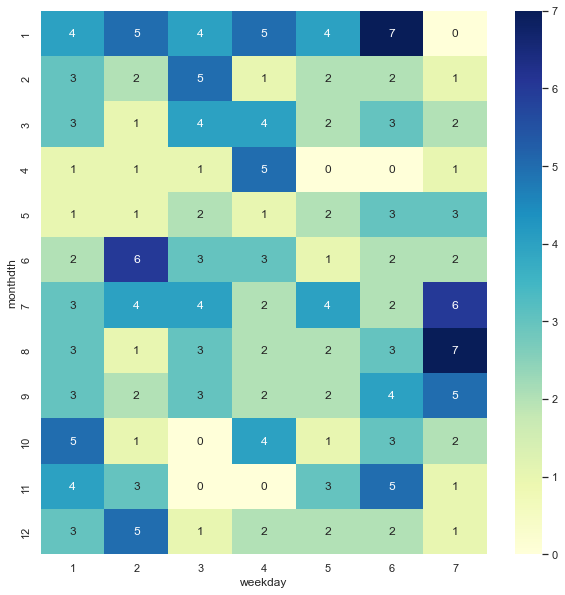

In [30]:
heaptable_trends = suicide.pivot_table(index = 'monthdth', columns = 'weekday', values = 'mandeath', aggfunc = np.sum)

plt.figure(figsize=(10, 10))
sns.heatmap(data = heaptable_trends,cmap='YlGnBu',annot = True, fmt="g")


The figure about tells us the suicide case number regarding to Month and weekday. 重灾区在1月的周六，8月的周日

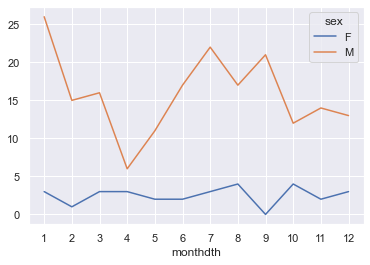

In [31]:
monthly_trends = suicide.pivot_table(index = 'monthdth', columns = 'sex', values = 'mandeath', aggfunc = np.sum)
monthly_trends.plot()
plt.xticks(np.arange(1, 13, step=1))
plt.show()

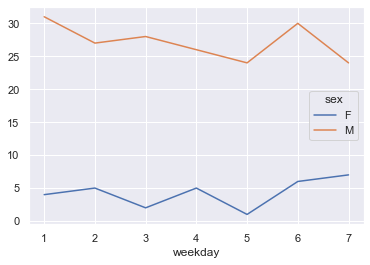

In [32]:
weekly_trends = suicide.pivot_table(index = 'weekday',columns= 'sex',values = 'mandeath', aggfunc = np.sum)
weekly_trends.plot()
plt.xticks(np.arange(1, 8, step=1))
plt.show()

Everyone Enjoys Friday

## 2.3 Gender & Age Analysis

Age Category Referred to :https://integrisok.com/resources/on-your-health/2015/october/stages-of-life-health-for-every-age

In [33]:
def get_age_group(x):
    if (x["age"] >= 0) &(x["age"] <= 1):
        return "Infant"
    if (x["age"] >= 2) &(x["age"] <= 4):
        return "Toddler"
    if (x["age"] >= 5) &(x["age"] <= 12):
        return "Child"
    if (x["age"] >= 13) &(x["age"] <= 19):
        return "Teen"
    if (x["age"] >= 20) &(x["age"] <= 39):
        return "Adult"
    if (x["age"] >= 40) &(x["age"] <= 59):
        return "Mid-age Adult"
    else:
        return "Senior"
    
suicide.loc[:,"Age Group"] = suicide.apply(get_age_group,axis=1)

<AxesSubplot:xlabel='Age Group', ylabel='sex'>

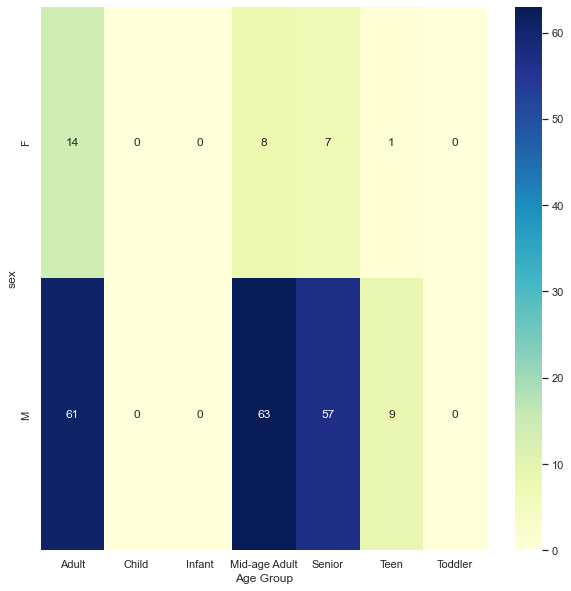

In [34]:
heaptable_genderage = suicide.pivot_table(index = 'sex', columns = 'Age Group', values = 'mandeath', aggfunc = np.sum)

plt.figure(figsize=(10, 10))
sns.heatmap(data = heaptable_genderage,cmap='YlGnBu',annot = True, fmt="g")

From the Figure above we can see that male people have larger potential to suicide than female.
More, Adult and Senior are more likely to suicide.

## 2.3 Gender & Martial Status Analysis

<AxesSubplot:xlabel='marstat', ylabel='sex'>

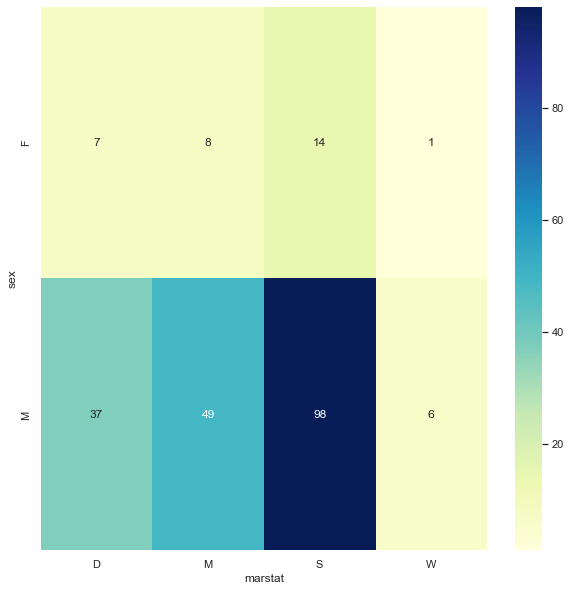

In [35]:
heaptable_gendermarstat = suicide.pivot_table(index = 'sex', columns = 'marstat', values = 'mandeath', aggfunc = np.sum)


plt.figure(figsize=(10, 10))


sns.heatmap(data = heaptable_gendermarstat,cmap='YlGnBu',annot = True, fmt="g")

We need to revise this part in order to get the ratio value of the stuff above.

In [36]:
percentage_gendermarstat = heaptable_gendermarstat.copy()
gender_list = ["F","M"]
marstat_list = ["W","M","S","D"]

for sex in gender_list:
    for marstat in marstat_list:
        percentage_gendermarstat.loc[sex,marstat] = percentage_gendermarstat.loc[sex,marstat]/len(suicide.loc[(suicide["sex"] == sex) & (suicide["marstat"] == marstat)])
    

<AxesSubplot:xlabel='marstat', ylabel='sex'>

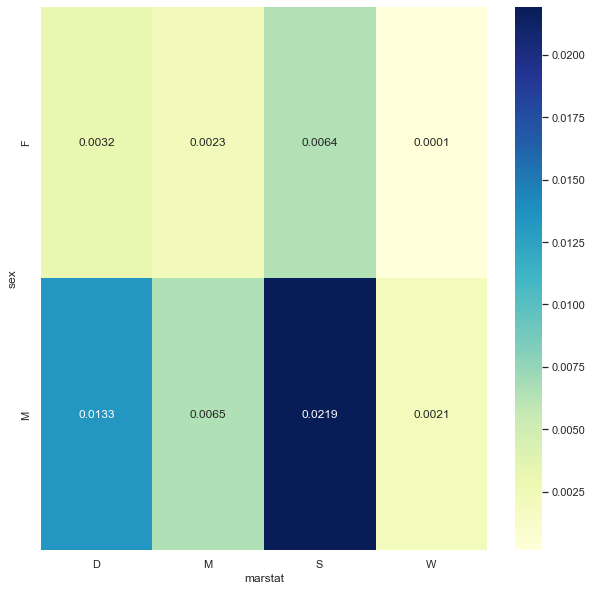

In [37]:
plt.figure(figsize=(10, 10))
sns.heatmap(data = percentage_gendermarstat,cmap='YlGnBu',annot = True, fmt=".4f")

# As suggested by Giri, here is a figure for representing the ratio of suicide cases over gender and martial status

# Conclusion: Single Male, in the Hell; (and why the HELL are WIDOWED people less likely to commit suicide???)

## 2.4 Gender Race Analysis

<AxesSubplot:xlabel='sex', ylabel='race'>

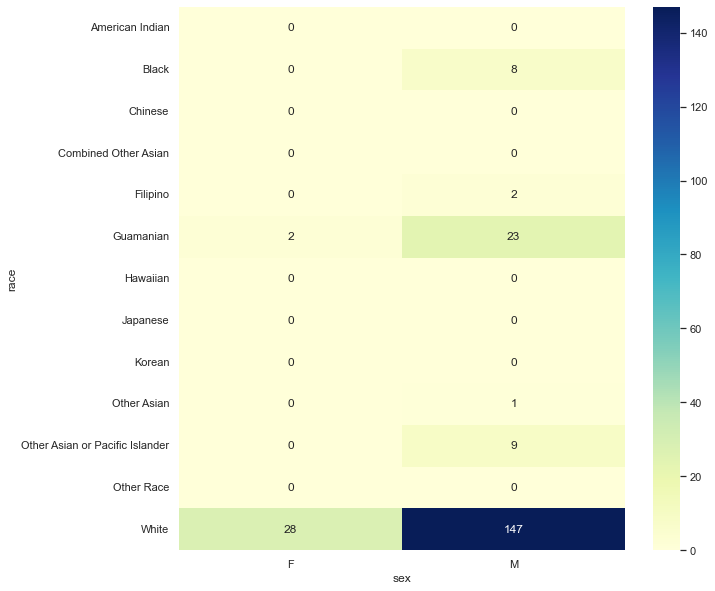

In [38]:
heaptable_genderrace = suicide.pivot_table(index = 'race', columns = 'sex', values = 'mandeath', aggfunc = np.sum)

plt.figure(figsize=(10, 10))
sns.heatmap(data = heaptable_genderrace,cmap='YlGnBu',annot = True, fmt="g")

## Because here simply counting the numbers does not make sense because our sample data is also super imbalanced. Therefore, getiing the ratio is more accurate.

<AxesSubplot:xlabel='sex', ylabel='race'>

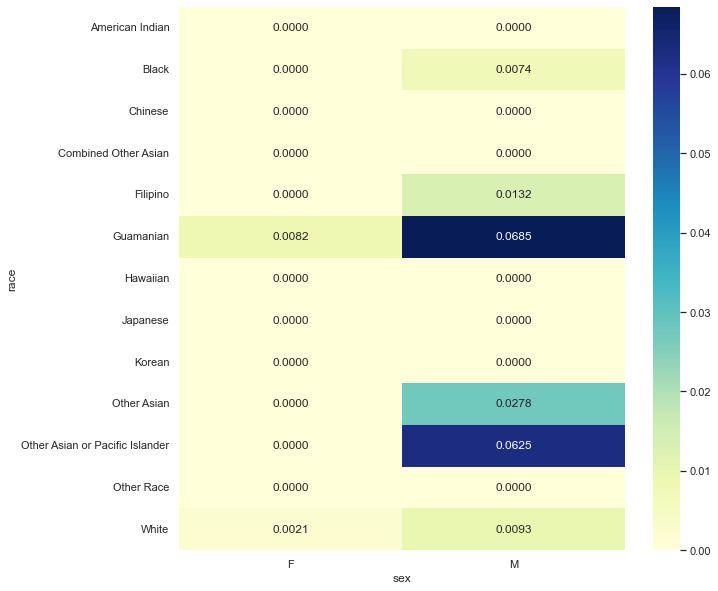

In [39]:
percentage_genderrace = heaptable_genderrace.copy()
gender_list = ["F","M"]
race_list = suicide['race'].unique()

for sex in gender_list:
    for race in race_list:
        percentage_genderrace.loc[race,sex] = percentage_genderrace.loc[race,sex]/len(suicide.loc[(suicide["sex"] == sex) & (suicide["race"] == race)])
    

plt.figure(figsize=(10, 10))
sns.heatmap(data = percentage_genderrace,cmap='YlGnBu',annot = True, fmt=".4f")

<AxesSubplot:xlabel='racer5', ylabel='sex'>

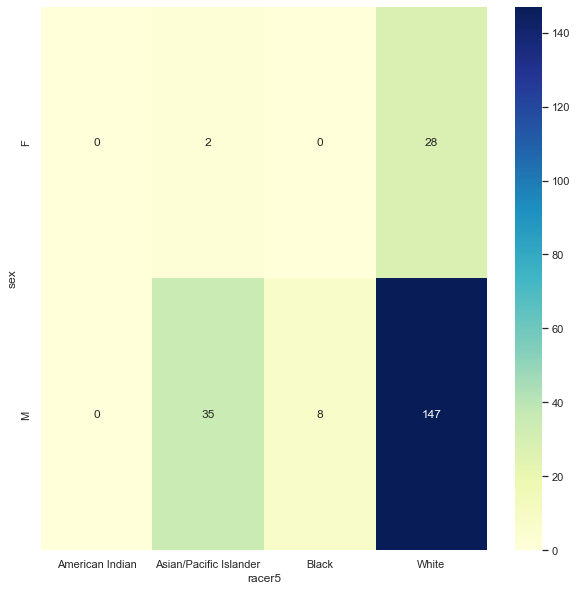

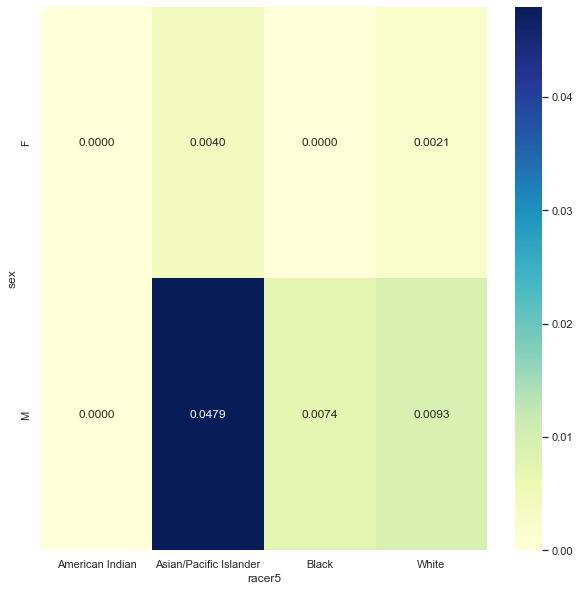

In [40]:
heaptable_genderrace = suicide.pivot_table(index = 'sex', columns = 'racer5', values = 'mandeath', aggfunc = np.sum)

plt.figure(figsize=(10, 10))
sns.heatmap(data = heaptable_genderrace,cmap='YlGnBu',annot = True, fmt="g")

percentage_genderrace = heaptable_genderrace.copy()
gender_list = ["F","M"]
racer5_list = suicide['racer5'].unique()

for sex in gender_list:
    for racer5 in racer5_list:
        percentage_genderrace.loc[sex,racer5] = percentage_genderrace.loc[sex,racer5]/len(suicide.loc[(suicide["sex"] == sex) & (suicide["racer5"] == racer5)])
    

plt.figure(figsize=(10, 10))
sns.heatmap(data = percentage_genderrace,cmap='YlGnBu',annot = True, fmt=".4f")

## 2.5 Education Level Analysis

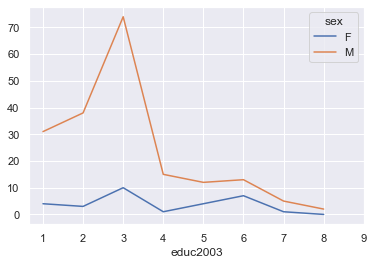

In [41]:
heaptable_educlevel = suicide.pivot_table(index = 'educ2003',columns='sex', values = 'mandeath', aggfunc = np.sum)
heaptable_educlevel.plot()
plt.xticks(np.arange(1, 10, step=1))
plt.show()

### Make a kernel density estimate of the distribution of the target values and interpret the distribution. 


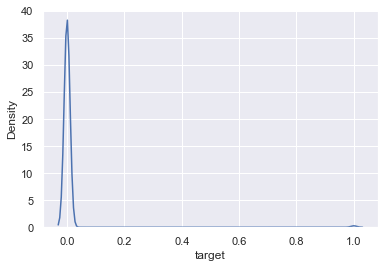

In [42]:
sns.kdeplot(data=suicide["mandeath"])
plt.xlabel("target")
plt.show()

from this distribution, we can see that the target variable follows a skewed distribution with the mean not centered with the median.

### Compute the correlation between each feature and the target and find the 3 most correlated features.


In [43]:
suicide.corr()

,restatus,educ2003,monthdth,age,placdth,weekday,mandeath,activity,injury,ucr358,...,race_Guamanian,race_Hawaiian,race_Japanese,race_Korean,race_Other Asian,race_Other Asian or Pacific Islander,race_Other Race,race_White,ICD_3,ICD_4
restatus,1.000000,0.015856,0.002689,-0.089857,-0.328754,0.008211,-0.033052,0.050311,0.047116,0.055093,...,-0.087837,-0.006677,-0.000948,0.012193,-0.026506,-0.055032,0.013926,0.080994,0.098898,NaN
educ2003,0.015856,1.000000,0.006763,-0.116087,-0.022639,0.001559,0.013545,0.015497,0.001093,-0.041878,...,0.005757,0.000852,0.006984,0.004278,-0.007689,-0.007969,-0.002359,0.005492,0.010932,NaN
monthdth,0.002689,0.006763,1.000000,-0.010005,-0.028832,-0.008074,-0.007328,-0.024100,-0.018592,-0.063954,...,0.012045,-0.000849,-0.000581,-0.012772,-0.005295,0.012915,-0.021695,-0.009162,0.046502,NaN
age,-0.089857,-0.116087,-0.010005,1.000000,0.001643,-0.003568,-0.126865,-0.344007,-0.135669,-0.200645,...,-0.082034,-0.014055,-0.004921,-0.016711,-0.032811,-0.089555,-0.001280,0.122925,-0.028273,NaN
placdth,-0.328754,-0.022639,-0.028832,0.001643,1.000000,0.005960,0.048940,0.163396,0.079834,0.091075,...,-0.051012,-0.001324,-0.003245,-0.006285,-0.021606,-0.035515,0.006140,0.037210,-0.244069,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
race_Other Asian or Pacific Islander,-0.055032,-0.007969,0.012915,-0.089555,-0.035515,-0.005595,0.032774,0.026653,0.004854,0.007892,...,-0.011586,-0.000825,-0.002021,-0.000825,-0.003784,1.000000,-0.004345,-0.264874,0.023690,NaN
race_Other Race,0.013926,-0.002359,-0.021695,-0.001280,0.006140,-0.002415,-0.004203,-0.001176,0.004894,-0.004005,...,-0.006869,-0.000489,-0.001198,-0.000489,-0.002244,-0.004345,1.000000,-0.157043,-0.000176,NaN
race_White,0.080994,0.005492,-0.009162,0.122925,0.037210,-0.010231,-0.031120,-0.049809,-0.022366,-0.019689,...,-0.418745,-0.029820,-0.073060,-0.029820,-0.136777,-0.264874,-0.157043,1.000000,-0.018954,NaN
ICD_3,0.098898,0.010932,0.046502,-0.028273,-0.244069,0.000193,-0.084626,-0.081908,-0.071160,-0.050784,...,0.020015,-0.002463,0.006295,-0.003541,-0.003053,0.023690,-0.000176,-0.018954,1.000000,NaN


In [44]:
correlation = suicide.corrwith(suicide['mandeath'])
correlationmost = correlation.loc[suicide.corrwith(suicide['mandeath'])>0.01]
correlationmost.sort_values()

marstat_D                               0.010589
educ2003                                0.013545
race_Other Asian or Pacific Islander    0.032774
placdth                                 0.048940
sex_M                                   0.052796
race40                                  0.056832
raceforvis                              0.059178
race_Guamanian                          0.059598
marstat_S                               0.062013
injury                                  0.090360
econdp_3                                0.092062
ucr39                                   0.124366
ucr113                                  0.157244
econds_2                                0.188015
ucr358                                  0.193842
activity                                0.343623
mandeath                                1.000000
dtype: float64

In [45]:
correlationleast = correlation.loc[suicide.corrwith(suicide['mandeath'])<-0.01]
correlationleast.sort_values()

age          -0.126865
ICD_3        -0.084626
ranum        -0.073685
sex_F        -0.052796
econdp_2     -0.051668
marstat_W    -0.047989
econds_4     -0.042763
econdp_4     -0.041531
econdp_5     -0.041084
eanum        -0.039596
econds_5     -0.034500
hispanic     -0.033772
restatus     -0.033052
race_White   -0.031120
econdp_6     -0.030264
econds_6     -0.027734
econdp_7     -0.022372
econds_7     -0.021115
econdp_8     -0.014822
marstat_M    -0.014721
econds_8     -0.014011
dtype: float64

In [46]:
suicide.columns.tolist()

['restatus',
 'educ2003',
 'monthdth',
 'sex',
 'age',
 'placdth',
 'marstat',
 'weekday',
 'injwork',
 'mandeath',
 'activity',
 'injury',
 'ucod',
 'ucr358',
 'ucr113',
 'ucr130',
 'ucr39',
 'eanum',
 'econdp_1',
 'enicon_1',
 'econdp_2',
 'econds_2',
 'enicon_2',
 'econdp_3',
 'econds_3',
 'enicon_3',
 'econdp_4',
 'econds_4',
 'enicon_4',
 'econdp_5',
 'econds_5',
 'enicon_5',
 'econdp_6',
 'econds_6',
 'enicon_6',
 'econdp_7',
 'econds_7',
 'enicon_7',
 'econdp_8',
 'econds_8',
 'enicon_8',
 'econdp_9',
 'econds_9',
 'enicon_9',
 'econdp_10',
 'econds_10',
 'enicon_10',
 'econdp_11',
 'econds_11',
 'enicon_11',
 'econdp_12',
 'econds_12',
 'enicon_12',
 'econdp_13',
 'econds_13',
 'enicon_13',
 'econdp_14',
 'econds_14',
 'enicon_14',
 'ranum',
 'record_1',
 'record_2',
 'record_3',
 'record_4',
 'record_5',
 'record_6',
 'record_7',
 'record_8',
 'record_9',
 'record_10',
 'record_11',
 'record_12',
 'record_13',
 'record_14',
 'race',
 'racer5',
 'hispanic',
 'race40',
 'sex_F',

In [47]:
#plt.figure(figsize=(58,58))
#sns.heatmap(suicide.corr(),annot=True, cmap='coolwarm',fmt='.2f')

In [48]:
#dfhalf = suicide[['mandeath','educ2003','sex','age','placdth',
# 'sex_F', 'sex_M', 'marstat_D', 'marstat_M','marstat_S', 'marstat_W',
#'race_American Indian', 'race_Black', 'race_Chinese', 'race_Filipino', 'race_Guamanian',
#'race_Hawaiian', 'race_Japanese', 'race_Korean', 'race_White','ranum','hispanic','restatus']]
#plt.figure(figsize=(20,20))
#sns.heatmap(dfhalf.corr(),annot=True, cmap='coolwarm',fmt='.3f')

In [49]:
suicide[['mandeath','educ2003','sex','age','placdth',
 'sex_F', 'sex_M', 'marstat_D', 'marstat_M','marstat_S', 'marstat_W',
'race_American Indian', 'race_Black', 'race_Chinese', 'race_Filipino', 'race_Guamanian',
'race_Hawaiian', 'race_Japanese', 'race_Korean', 'race_White']]

,mandeath,educ2003,sex,age,placdth,sex_F,sex_M,marstat_D,marstat_M,marstat_S,marstat_W,race_American Indian,race_Black,race_Chinese,race_Filipino,race_Guamanian,race_Hawaiian,race_Japanese,race_Korean,race_White
0,0.0,3,M,72.0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0.0,3,M,43.0,3,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0.0,1,F,64.0,3,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0.0,3,M,85.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0.0,3,M,76.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34418,0.0,1,F,95.0,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
34419,0.0,3,F,80.0,4,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
34420,0.0,1,F,103.0,4,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
34422,0.0,4,F,65.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [50]:
suicide['raceforvis']

0        58
1        58
2        58
3        58
4        58
         ..
34418     2
34419     2
34420     2
34422     1
34424     2
Name: raceforvis, Length: 32302, dtype: int64

In [51]:
suicide["raceforvis"].replace({18: 8, 28: 9, 38: 10,\
                         48:11, 58: 12,68:13,78:14}, inplace=True)
suicide["raceforvis"].describe()

count    32302.000000
mean         1.377159
std          1.743515
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: raceforvis, dtype: float64

In [52]:
suicide['mandeath'] =  suicide['mandeath'].astype(int)
suicide['mandeath']

0        0
1        0
2        0
3        0
4        0
        ..
34418    0
34419    0
34420    0
34422    0
34424    0
Name: mandeath, Length: 32302, dtype: int32

(array([2.933e+04, 1.800e+03, 2.200e+01, 1.800e+01, 3.000e+00, 4.790e+02,
        3.000e+00, 0.000e+00, 5.810e+02, 6.600e+01]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

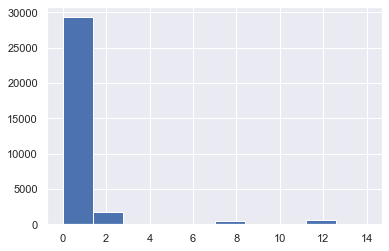

In [53]:
plt.hist(suicide['raceforvis'])

(array([32082.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   220.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

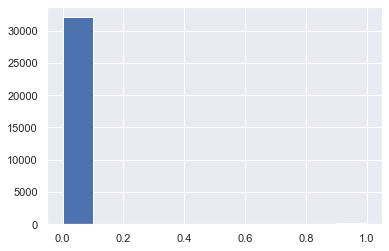

In [54]:
plt.hist(suicide['mandeath'])

In [55]:
suicide["age"].describe()

count    32302.000000
mean        74.029401
std         16.934283
min          0.000006
25%         66.000000
50%         77.000000
75%         86.000000
max        109.000000
Name: age, dtype: float64

(array([ 128.,  191.,  674.,  973., 1940., 4143., 7471., 9945., 6250.,
         587.]),
 array([5.70776256e-06, 1.09000051e+01, 2.18000046e+01, 3.27000040e+01,
        4.36000034e+01, 5.45000029e+01, 6.54000023e+01, 7.63000017e+01,
        8.72000011e+01, 9.81000006e+01, 1.09000000e+02]),
 <BarContainer object of 10 artists>)

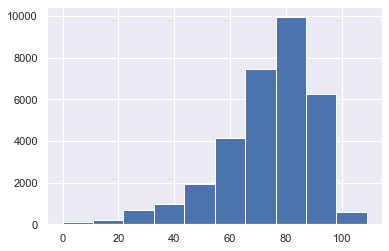

In [56]:
plt.hist(suicide['age'])

(array([17644.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14658.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

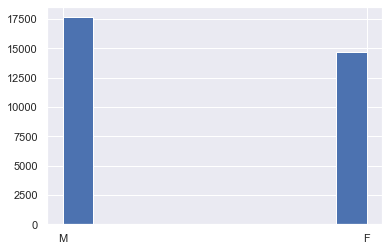

In [57]:
plt.hist(suicide['sex'])

(array([11315.,  4417.,  8053.,     0.,  1591.,  2396.,     0.,  3243.,
          857.,   430.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

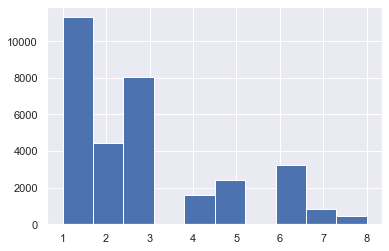

In [58]:
plt.hist(suicide['educ2003'])

(array([11096.,     0.,     0.,  6659.,     0.,     0.,  9577.,     0.,
            0.,  4970.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

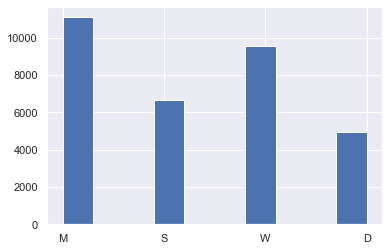

In [59]:
plt.hist(suicide['marstat'])

(array([1.3788e+04, 1.7960e+03, 0.0000e+00, 5.7800e+02, 0.0000e+00,
        1.1364e+04, 3.0000e+00, 0.0000e+00, 3.2330e+03, 1.5400e+03]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

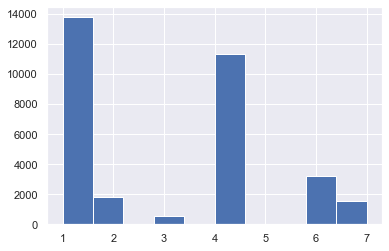

In [60]:
plt.hist(suicide['placdth'])

([<matplotlib.axis.XTick at 0x23dd8431f40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

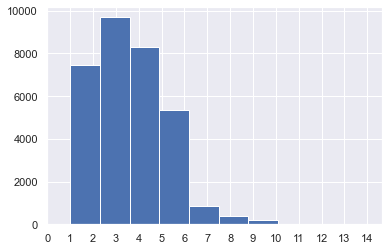

In [61]:
plt.hist(suicide['ranum'])
plt.xticks(np.arange(15,step=1))

([<matplotlib.axis.XTick at 0x23dd7b822b0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

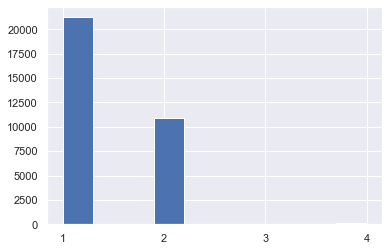

In [62]:
plt.hist(suicide['restatus'])
plt.xticks([1,2,3,4])

(array([ 1927., 30177.,    67.,     0.,     0.,     0.,     0.,     0.,
            0.,   131.]),
 array([100. , 189.8, 279.6, 369.4, 459.2, 549. , 638.8, 728.6, 818.4,
        908.2, 998. ]),
 <BarContainer object of 10 artists>)

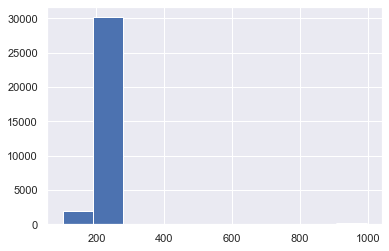

In [63]:
plt.hist(suicide['hispanic'])

In [64]:
suicide_people=suicide.loc[suicide['mandeath']==1]

(array([190.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  30.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

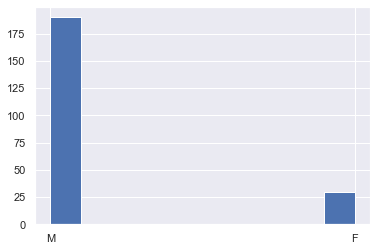

In [65]:
plt.hist(suicide_people['sex'])

([<matplotlib.axis.XTick at 0x23dd7ebae20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

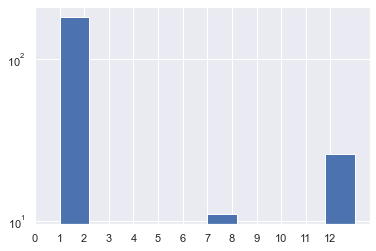

In [66]:
plt.hist(suicide_people['raceforvis'],log=True)
plt.xticks(np.arange(max(suicide_people['raceforvis']),step=1))

In [67]:
white_suicide_ratio_all = sum(suicide_people['raceforvis']==1)/len(suicide_people)
white_suicide_ratio_all

0.7954545454545454

In [68]:
white_suicide_ratio_suicide = sum(suicide['raceforvis']==1)/len(suicide)
white_suicide_ratio_suicide

0.9054238127670113

([<matplotlib.axis.XTick at 0x23dd862dac0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

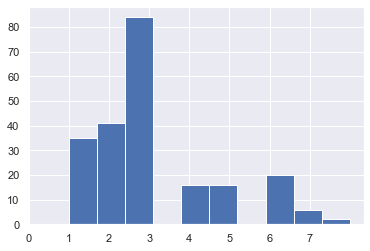

In [69]:
plt.hist(suicide_people['educ2003'])
plt.xticks(np.arange(max(suicide_people['educ2003']),step=1))

(array([14., 30., 31., 28., 25., 32., 23., 17., 17.,  3.]),
 array([14. , 21.8, 29.6, 37.4, 45.2, 53. , 60.8, 68.6, 76.4, 84.2, 92. ]),
 <BarContainer object of 10 artists>)

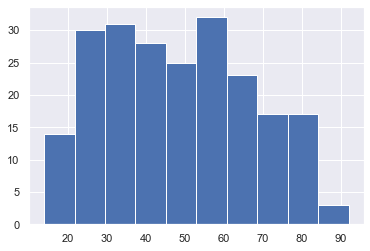

In [70]:
plt.hist(suicide_people['age'])

(array([ 57.,   0.,   0., 112.,   0.,   0.,  44.,   0.,   0.,   7.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

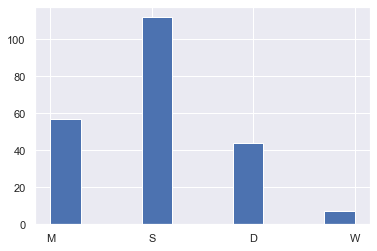

In [71]:
plt.hist(suicide_people['marstat'])

(array([ 15.,   5.,   0.,  35.,   0., 129.,   0.,   0.,   0.,  36.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

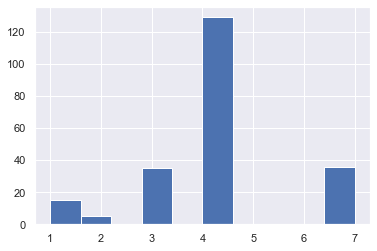

In [72]:
plt.hist(suicide_people['placdth'])

(array([183.,   0.,   0.,  30.,   0.,   0.,   3.,   0.,   0.,   4.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

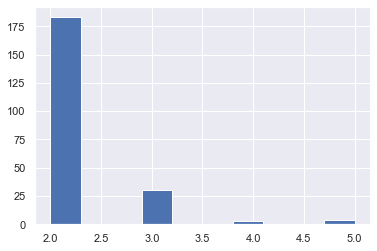

In [73]:
plt.hist(suicide_people['ranum'])

(array([191.,   0.,   0.,  27.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

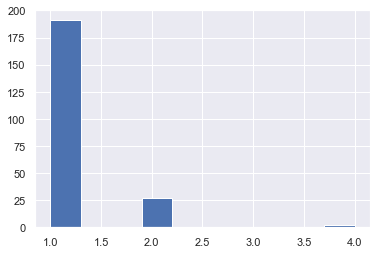

In [74]:
plt.hist(suicide_people['restatus'])

(array([ 52., 166.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([100. , 189.8, 279.6, 369.4, 459.2, 549. , 638.8, 728.6, 818.4,
        908.2, 998. ]),
 <BarContainer object of 10 artists>)

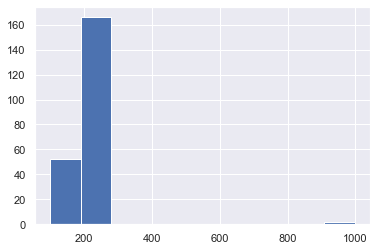

In [75]:
plt.hist(suicide_people['hispanic'])

downsampling

In [85]:
suicide_people=suicide.loc[suicide['mandeath'] == 1]
no_suicide_people = suicide.loc[suicide['mandeath'] == 0]

In [86]:
suicide_people = suicide_people[['mandeath','educ2003','age','placdth',
 'sex_F', 'sex_M', 'marstat_D', 'marstat_M','marstat_S', 'marstat_W',
'race_American Indian', 'race_Black', 'race_Chinese', 'race_Filipino', 'race_Guamanian',
'race_Hawaiian', 'race_Japanese', 'race_Korean', 'race_White']]
no_suicide_people = no_suicide_people[['mandeath','educ2003','age','placdth',
 'sex_F', 'sex_M', 'marstat_D', 'marstat_M','marstat_S', 'marstat_W',
'race_American Indian', 'race_Black', 'race_Chinese', 'race_Filipino', 'race_Guamanian',
'race_Hawaiian', 'race_Japanese', 'race_Korean', 'race_White']]

In [87]:
from sklearn.utils import resample
no_suicide_people = resample(no_suicide_people,replace=True,n_samples=len(suicide_people),random_state=42)

In [88]:
no_suicide_people

,mandeath,educ2003,age,placdth,sex_F,sex_M,marstat_D,marstat_M,marstat_S,marstat_W,race_American Indian,race_Black,race_Chinese,race_Filipino,race_Guamanian,race_Hawaiian,race_Japanese,race_Korean,race_White
24945,0,5,54.0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
16696,0,3,82.0,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1053,0,1,72.0,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5771,0,1,66.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
31485,0,3,42.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10506,0,4,60.0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
29388,0,2,34.0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
20625,0,1,93.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
23517,0,3,95.0,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [91]:
final_model_data = pd.concat([suicide_people ,no_suicide_people])
final_model_data

,mandeath,educ2003,age,placdth,sex_F,sex_M,marstat_D,marstat_M,marstat_S,marstat_W,race_American Indian,race_Black,race_Chinese,race_Filipino,race_Guamanian,race_Hawaiian,race_Japanese,race_Korean,race_White
24,1,3,43.0,3,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
34,1,2,37.0,3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
83,1,2,47.0,3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
115,1,3,32.0,3,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
138,1,7,37.0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10506,0,4,60.0,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
29388,0,2,34.0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
20625,0,1,93.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
23517,0,3,95.0,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1


Model

In [93]:
Y = final_model_data[['mandeath']]
X = final_model_data[['educ2003','age','placdth',
 'sex_F', 'sex_M', 'marstat_D', 'marstat_M','marstat_S', 'marstat_W',
'race_American Indian', 'race_Black', 'race_Chinese', 'race_Filipino', 'race_Guamanian',
'race_Hawaiian', 'race_Japanese', 'race_Korean', 'race_White']]

In [94]:
X = StandardScaler().fit_transform(X) #Standardize features by removing the mean and scaling to unit variance.

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Decision tree

In [101]:
DecisionTree = tree.DecisionTreeClassifier()
DecisionTree = DecisionTree.fit(X_train, y_train)
DecisionTree.score(X_test, y_test, sample_weight=None)

0.7945205479452054